# DLToolboxImg: Part 3

# Table of Contents
- [Define File Iterator](#fileiter)
- [Define Evaluation Metric](#metric)
- [Define Model Architecture](#arch)
- [Select Learning Rate](#lrfind)
- [Select Initial weights](#weights)
- [Train Model](#train)
- [Save Model](#save)
- [Evaluate Model](#eval)
- [Modify Learnig Parameters](#train2)
- [Resume Training](#resume)
- [Compare Models](#compare)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import mynnet7 as nn

## Define File Iterator

In [4]:
import mxnet as mx
import sys, os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import pandas as pd
import re
from mxnet.io import DataIter
from mxnet.io import DataBatch
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from collections import namedtuple
import pickle

Batch = namedtuple('Batch', ['data'])

BATCH_SIZE,INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x = 8,32,32,32
def print_inferred_shape(net):
    ar, ou, au = net.infer_shape(data=(BATCH_SIZE, 1, INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x))
    print(net.name,ou)
class FileIter(DataIter):
    def __init__(self, path,
                 data_name="data",
                 label_name="softmax_label",
                 batch_size=1,
                 do_augment=False,
                 mean_image=.2815,
                 std_image = .2807):

        
        self.epoch = 0
        self.mean_image = mean_image
        self.std_image = std_image
        
        super(FileIter, self).__init__()
        self.batch_size = batch_size
        self.do_augment=do_augment


        #self.mean = cv2.imread(mean_image, cv2.IMREAD_GRAYSCALE)

        self.data_name = data_name
        self.label_name = label_name

        self.record = mx.recordio.MXRecordIO(path, 'r')

        
        def readrecord(record):
            record.reset()
            num_data=0
            while True:
                item = record.read()
                num_data+=1
                if not item:
                    break
            return num_data-1
        
        
        self.num_data = readrecord(self.record)#len(open(self.flist_name, 'r').readlines())
        
        self.cursor = -1
        self.record.reset()

        self.data, self.label = self._read()
        self.reset()

    def _read(self):
        """get two list, each list contains two elements: name and nd.array value"""
                
        data = {}
        label = {}

        dd = []
        ll = []
        for i in range(0, self.batch_size):
            
            item = self.record.read()            
            header, l = mx.recordio.unpack_img(item)
            
            d=header.label

            d=d.reshape((32,32,32))- self.mean_image
            d = d/self.std_image
            d = np.expand_dims(d, axis=0) 
            d = np.expand_dims(d, axis=0)
            

            l=l.reshape((32*32*32))
            l = np.expand_dims(l, axis=0)
            l=l.astype(float)

            dd.append(d)
            ll.append(l)

        d = np.vstack(dd)
        l = np.vstack(ll)
        data[self.data_name] = d
        label[self.label_name] = l
        res = list(data.items()), list(label.items())
        return res

    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.data]
        # print "data : " + str(res)
        return res

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.label]
        return res
    

    def reset(self):
        self.cursor = -1
        self.record.reset()
        self.epoch += 1

    def getpad(self):
        return 0

    def iter_next(self):
        self.cursor += self.batch_size
        if self.cursor < self.num_data:
            return True
        else:
            return False

    def eof(self):
        res = self.cursor >= self.num_data
        return res

    def next(self):
        """return one dict which contains "data" and "label" """
        if self.iter_next():
            self.data, self.label = self._read()
 
            res = DataBatch(data=[mx.nd.array(self.data[0][1])], label=[mx.nd.array(self.label[0][1])], pad=self.getpad(), index=None)

            return res
        else:
            raise StopIteration



In [5]:
interm_dir4='/home/mas/x110/data'
train_data_path=interm_dir4+'/Train6Oct2018augment.rec'
BATCH_SIZE=1
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE)

In [6]:
train_iter.reset()

In [7]:
batch = train_iter.next()
X =  batch.data[0][0][0].asnumpy()
Y = batch.label[0].reshape((32,32,32)).asnumpy()

In [8]:
X.shape,Y.shape

((32, 32, 32), (32, 32, 32))

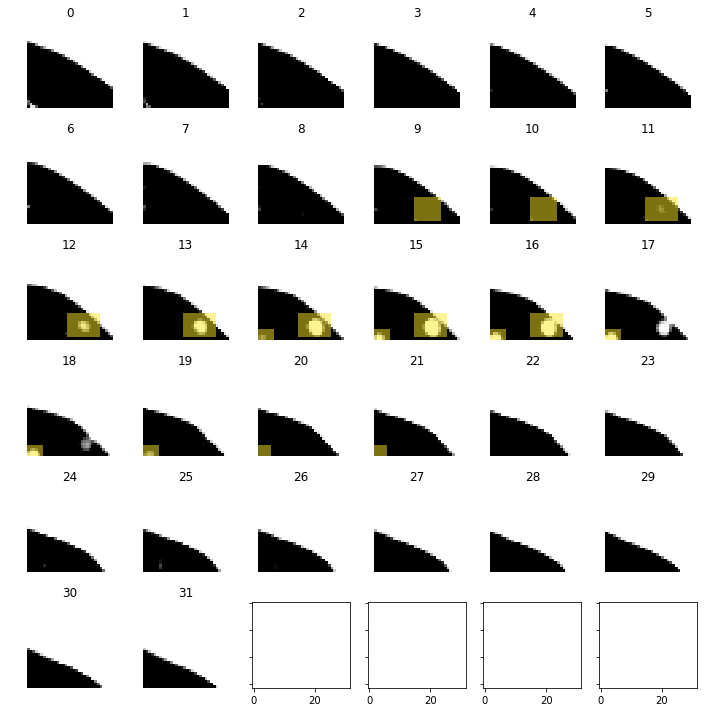

In [9]:
zs=32

X2,Z2 = X,Y
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=6
num_cols=6

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(10,10))

ind=np.arange(0,32)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.5,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title(str(ii))
      
plt.tight_layout()

## Find mean of images

In [10]:
interm_dir4='/home/mas/x110/data'
train_data_path=interm_dir4+'/Train6Oct2018augment.rec'
BATCH_SIZE=1
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
train_iter.reset()
x_mean = np.zeros((32,32,32))
for i,batch in enumerate(train_iter):
    X =  batch.data[0][0][0].asnumpy()
    x_mean+=X
x_mean=np.mean(x_mean/i)
x_mean#x_mean=.2815

0.2815327279660965

In [11]:
x_mean=.2815

## Find variance of images

In [12]:
interm_dir4='/home/mas/x110/data'
train_data_path=interm_dir4+'/Train6Oct2018augment.rec'
BATCH_SIZE=1
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
train_iter.reset()
x_var = np.zeros((32,32,32))
for i,batch in enumerate(train_iter):
    X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
    x_var+=X
#x_var=x_var/(i-1)
#x_var#x_mean=.2815
N = i*32*32*32
x_var = np.sum(x_var)/(N-1)
x_var#x_var = .07877
x_std = np.sqrt(x_var)#x_std=.2807
x_std

0.28066587175585705

In [13]:
x_std=.2807

In [14]:
BATCH_SIZE=32
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'data': (32, 1, 32, 32, 32), 'softmax_label': (32, 32768)}


In [15]:
print(input_shapes)

{'data': (32, 1, 32, 32, 32), 'softmax_label': (32, 32768)}


In [16]:
BATCH_SIZE=32
valid_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean)

In [17]:
train_iter.reset()
valid_iter.reset()

In [18]:
## Optimizer

In [19]:
# ===============Optimizer=================                        
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,momentum=0.99,wd=0.000001)
    
updater = mx.optimizer.get_updater(opt)

In [20]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=nn.dice_coef2)

## Define Model Architecture

In [21]:
network = nn.get_net_317()
init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

In [22]:
# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

In [23]:
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)

/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
!mkdir /home/mas/x110/model

mkdir: cannot create directory ‘/home/mas/x110/model’: File exists


In [25]:
prefix = "/home/mas/x110/model/oct22"

In [26]:
### import time

for epoch in range(0,500):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 61.108887910842896 Epoch: 0 trainloss: -0.041085895 validloss: -0.026820177
time: 12.314754009246826 Epoch: 1 trainloss: -0.050864074 validloss: -0.03925276
time: 12.701289892196655 Epoch: 2 trainloss: -0.055914406 validloss: -0.06592959
time: 12.407852411270142 Epoch: 3 trainloss: -0.05932545 validloss: -0.07978245
time: 12.140162944793701 Epoch: 4 trainloss: -0.062212154 validloss: -0.08736262
time: 13.051051616668701 Epoch: 5 trainloss: -0.06392189 validloss: -0.08786523
time: 13.22016429901123 Epoch: 6 trainloss: -0.0649905 validloss: -0.08121211
time: 12.160020589828491 Epoch: 7 trainloss: -0.06615744 validloss: -0.066448666
time: 12.137198448181152 Epoch: 8 trainloss: -0.06712411 validloss: -0.05178488
time: 12.135893821716309 Epoch: 9 trainloss: -0.06759959 validloss: -0.046065763
time: 12.133606195449829 Epoch: 10 trainloss: -0.06785477 validloss: -0.044711884
time: 12.137626647949219 Epoch: 11 trainloss: -0.06811637 validloss: -0.044732362
time: 12.997271299362183 Epoch:

time: 12.000387191772461 Epoch: 101 trainloss: -0.14612524 validloss: -0.1593335
time: 11.99749207496643 Epoch: 102 trainloss: -0.15168524 validloss: -0.09443884
time: 12.035693168640137 Epoch: 103 trainloss: -0.1509645 validloss: -0.1525645
time: 11.996749639511108 Epoch: 104 trainloss: -0.15425253 validloss: -0.14542022
time: 12.004433870315552 Epoch: 105 trainloss: -0.15724267 validloss: -0.16147232
time: 11.998065710067749 Epoch: 106 trainloss: -0.16117159 validloss: -0.15353289
time: 11.996292114257812 Epoch: 107 trainloss: -0.1632775 validloss: -0.15845576
time: 12.011204957962036 Epoch: 108 trainloss: -0.16874446 validloss: -0.15227579
time: 11.999666690826416 Epoch: 109 trainloss: -0.16950491 validloss: -0.14798763
time: 12.004970073699951 Epoch: 110 trainloss: -0.17347401 validloss: -0.14460057
time: 11.995250940322876 Epoch: 111 trainloss: -0.17644148 validloss: -0.17699358
time: 12.008552074432373 Epoch: 112 trainloss: -0.18150766 validloss: -0.18665655
time: 12.028716564178

time: 11.99720025062561 Epoch: 202 trainloss: -0.8325465 validloss: -0.7977465
time: 12.038956880569458 Epoch: 203 trainloss: -0.8323577 validloss: -0.80578953
time: 11.99718165397644 Epoch: 204 trainloss: -0.8342968 validloss: -0.8141737
time: 12.003759622573853 Epoch: 205 trainloss: -0.8389137 validloss: -0.8176696
time: 11.9983651638031 Epoch: 206 trainloss: -0.83760273 validloss: -0.8139145
time: 11.996835708618164 Epoch: 207 trainloss: -0.8434554 validloss: -0.8033476
time: 12.01524567604065 Epoch: 208 trainloss: -0.84443253 validloss: -0.80460066
time: 11.998273134231567 Epoch: 209 trainloss: -0.84146565 validloss: -0.80680746
time: 12.00507378578186 Epoch: 210 trainloss: -0.8465839 validloss: -0.7938304
time: 11.996498823165894 Epoch: 211 trainloss: -0.8456365 validloss: -0.80042595
time: 11.998693466186523 Epoch: 212 trainloss: -0.8459581 validloss: -0.77036315
time: 12.039861917495728 Epoch: 213 trainloss: -0.8534434 validloss: -0.7408756
time: 11.99933409690857 Epoch: 214 tra

time: 11.993689060211182 Epoch: 304 trainloss: -0.9301636 validloss: -0.9194725
time: 11.999512910842896 Epoch: 305 trainloss: -0.9319958 validloss: -0.92046016
time: 11.999897718429565 Epoch: 306 trainloss: -0.9322364 validloss: -0.9213246
time: 12.005838632583618 Epoch: 307 trainloss: -0.9338003 validloss: -0.9206073
time: 12.019343852996826 Epoch: 308 trainloss: -0.93242115 validloss: -0.91950095
time: 12.002679347991943 Epoch: 309 trainloss: -0.93249416 validloss: -0.917308
time: 12.00063705444336 Epoch: 310 trainloss: -0.9345398 validloss: -0.9129385
time: 12.00010871887207 Epoch: 311 trainloss: -0.9355279 validloss: -0.9049392
time: 12.001149654388428 Epoch: 312 trainloss: -0.93437344 validloss: -0.89522916
time: 12.043452501296997 Epoch: 313 trainloss: -0.9361125 validloss: -0.8854922
time: 11.995763301849365 Epoch: 314 trainloss: -0.9375264 validloss: -0.8798342
time: 11.996594190597534 Epoch: 315 trainloss: -0.9392034 validloss: -0.8821309
time: 12.00124716758728 Epoch: 316 tr

time: 11.996141910552979 Epoch: 406 trainloss: -0.9713069 validloss: -0.97644657
time: 12.02053451538086 Epoch: 407 trainloss: -0.97128314 validloss: -0.97682774
time: 12.002334594726562 Epoch: 408 trainloss: -0.9725547 validloss: -0.975646
time: 11.996904373168945 Epoch: 409 trainloss: -0.97376424 validloss: -0.9734314
time: 12.00120234489441 Epoch: 410 trainloss: -0.9726722 validloss: -0.9730498
time: 12.016140222549438 Epoch: 411 trainloss: -0.9736831 validloss: -0.9745978
time: 12.0397629737854 Epoch: 412 trainloss: -0.97252095 validloss: -0.97680855
time: 11.999475240707397 Epoch: 413 trainloss: -0.9727829 validloss: -0.977785
time: 11.99841594696045 Epoch: 414 trainloss: -0.9739672 validloss: -0.9765686
time: 11.996825933456421 Epoch: 415 trainloss: -0.9748907 validloss: -0.9746278
time: 11.99435544013977 Epoch: 416 trainloss: -0.9750318 validloss: -0.97325134
time: 12.01926064491272 Epoch: 417 trainloss: -0.97527707 validloss: -0.97351265
time: 11.997172832489014 Epoch: 418 trai

In [27]:
def get_sample_at(valid_iter,n):
    valid_iter.reset()
    for i in range(n-1):
        valid_iter.next()
    return valid_iter.next()

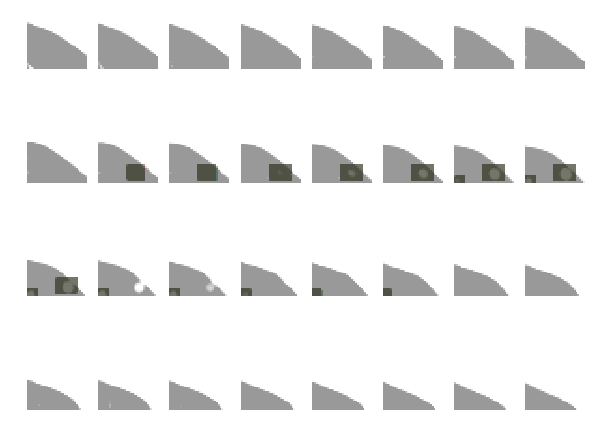

In [30]:
n=0
batch = get_sample_at(train_iter,n)


data[:] = batch.data[0]       
label[:] = batch.label[0]
# predict
outputs = exe.forward(is_train=False)


p = outputs[0][0].asnumpy().reshape(32,32,32)



X = batch.data[0][0][0].asnumpy()
Y = batch.label[0][0].asnumpy().reshape((32,32,32))
                              
img = X
msk1 = Y
msk2 = p>.5#.001
msk2=msk2*1
msk1= np.ma.masked_where(msk1 == 0, msk1)
msk2= np.ma.masked_where(msk2 == 0, msk2)

zs=32
num_rows=np.ceil(zs/8).astype(int)
f, plots = plt.subplots(num_rows, 8, sharex='col', sharey='row', figsize=(10, 8))
for i in range(zs):
    plots[i // 8, i % 8].axis('off')
    plots[i // 8, i % 8].imshow(img[i], cmap=plt.cm.gray,alpha=.4,vmin=0,vmax=1)
    plots[i // 8, i % 8].imshow(msk1[i],interpolation='none', cmap=plt.cm.Reds, alpha=.4, vmin=0, vmax=1)
    plots[i // 8, i % 8].imshow(msk2[i],interpolation='none', cmap=plt.cm.Greens, alpha=0.4, vmin=0, vmax=1)

